## **Import dependencies**

In [802]:
! pip install WordCloud --q

In [803]:
# Data Science Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Text Processing Libraries
import string
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# WordCloud for text visualization
from wordcloud import WordCloud

# NLTK for natural language processing
import nltk
from nltk.corpus import stopwords    # For stopwords
from nltk.tokenize import word_tokenize # For tokenization
from nltk.stem import PorterStemmer, WordNetLemmatizer # For stemming and lemmatization

# Downloading NLTK data
nltk.download('stopwords')   # Downloading stopwords data
nltk.download('punkt')       # Downloading tokenizer data
nltk.download('wordnet')     # Downloading WordNet data for lemmatization


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/santoshkumar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/santoshkumar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/santoshkumar/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## **Load the dataset:**

In [805]:
df= pd.read_csv("/Users/santoshkumaR/anaconda_project/MLOPS-Complete-ML-Pipeline/experiment/spam.csv")
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


## **Remove the columns which are not required**

In [807]:
df=df[["v2","v1"]].rename(columns= {"v2":"text","v1":"target"})

## **Know your data**

In [809]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5572 non-null   object
 1   target  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [810]:
df.isna().sum()

text      0
target    0
dtype: int64

In [811]:
df.duplicated().sum()

403

In [812]:
df.drop_duplicates(keep="first", inplace=True)
df.reset_index(drop=True, inplace=True)


In [813]:
df.duplicated().sum()

0

In [814]:
df.target.describe()

count     5169
unique       2
top        ham
freq      4516
Name: target, dtype: object

In [815]:
df

,text,target
0,"Go until jurong point, crazy.. Available only ...",ham
1,Ok lar... Joking wif u oni...,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,spam
3,U dun say so early hor... U c already then say...,ham
4,"Nah I don't think he goes to usf, he lives aro...",ham
...,...,...
5164,This is the 2nd time we have tried 2 contact u...,spam
5165,Will Ì_ b going to esplanade fr home?,ham
5166,"Pity, * was in mood for that. So...any other s...",ham
5167,The guy did some bitching but I acted like i'd...,ham


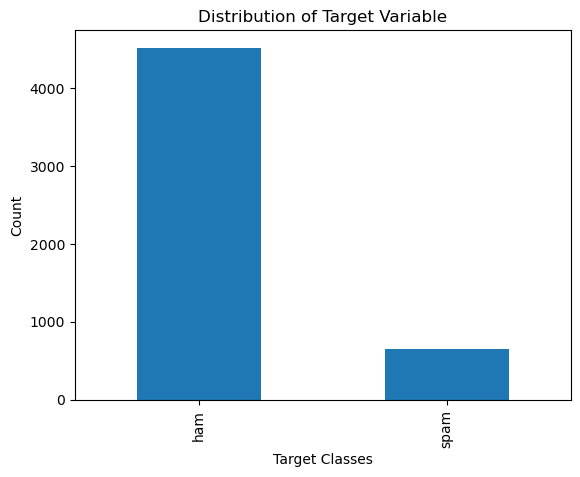

In [816]:
df.target.value_counts().plot(kind='bar')
plt.xlabel("Target Classes")
plt.ylabel("Count")
plt.title("Distribution of Target Variable")
plt.show()

### **observation:**
- Data is highly imbalance and having duplicate values

## **Basic data cleaning:**

In [819]:
# make a function to clean the text column
def clean(df,col):
    return df.assign(
        text= df[col].str.lower()
                     .str.strip()
                     .str.replace(r'[^a-zA-Z0-9\s]', ' ', regex=True)
         )


In [820]:
cleaned_df=df.pipe(clean, col="text")

In [821]:
cleaned_df['text'].iloc[2935]

'staff science nus edu sg  phyhcmk teaching pc1323'

## **Data Preprocessing & feature engineering:**


























In [823]:
# Define the text preprocessing function with additional features
def text_preprocessing(data, col):
    ps = PorterStemmer()

    # Process the text and extract features
    processed_col = data[col].apply(lambda x: ' '.join([ps.stem(word) for word in word_tokenize(x)]))
    
    # Extract features
    text_length = processed_col.str.len()  # Number of characters in the original text
    word_count = processed_col.apply(lambda x: len([word for word in word_tokenize(x) ]))  # Number of words
    avg_word_length = (processed_col
                       .apply(lambda x: sum(len(word) for word in word_tokenize(x) ) 
                                          / len([word for word in word_tokenize(x) ]) 
                                          if len([word for word in word_tokenize(x) ]) > 0 else 0)  # Average word length 
                       )
    
    # Add the new features to the dataframe
    processed_data=pd.DataFrame()
    processed_data['text'] = processed_col
    processed_data['text_length'] = text_length
    processed_data['word_count'] = word_count
    processed_data['avg_word_length'] = avg_word_length
    
    return processed_data.join(data.iloc[:,-1])

In [824]:
final_df=cleaned_df.pipe(text_preprocessing, col="text")
final_df.head(5)

,text,text_length,word_count,avg_word_length,target
0,go until jurong point crazi avail onli in bugi...,96,20,3.850000,ham
1,ok lar joke wif u oni,21,6,2.666667,ham
2,free entri in 2 a wkli comp to win fa cup fina...,152,33,3.636364,spam
3,u dun say so earli hor u c alreadi then say,43,11,3.000000,ham
4,nah i don t think he goe to usf he live around...,58,14,3.214286,ham


### **Wordcloud for spam message:**

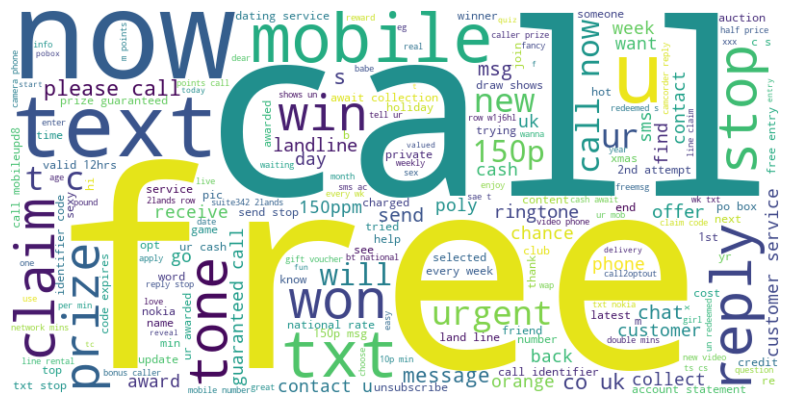

In [826]:
# Combine all text messages into a single string
text_data = " ".join(cleaned_df[final_df.target=="spam"].text.astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### **Wordcloud for ham message:**

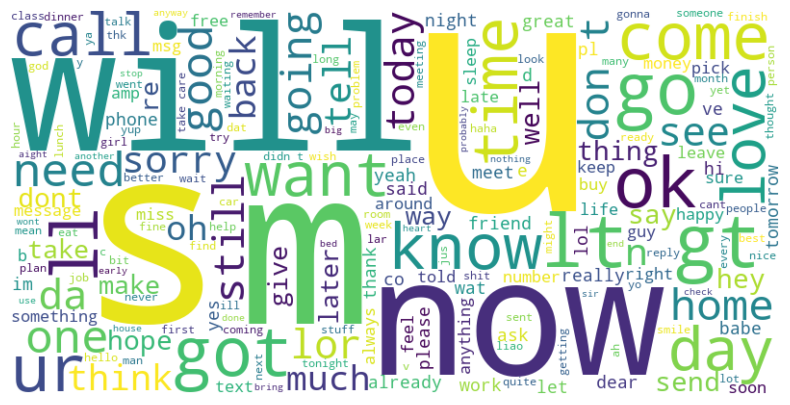

In [828]:
# Combine all text messages into a single string
text_data = " ".join(cleaned_df[final_df.target=="ham"].text.astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [829]:
cleaned_df.text[1787]

'you got job in wipro  you will get every thing in life in 2 or 3 years '

In [830]:
final_df.text[1787]

'you got job in wipro you will get everi thing in life in 2 or 3 year'

In [831]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5169 entries, 0 to 5168
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   text             5169 non-null   object 
 1   text_length      5169 non-null   int64  
 2   word_count       5169 non-null   int64  
 3   avg_word_length  5169 non-null   float64
 4   target           5169 non-null   object 
dtypes: float64(1), int64(2), object(2)
memory usage: 202.0+ KB


In [832]:
final_df

,text,text_length,word_count,avg_word_length,target
0,go until jurong point crazi avail onli in bugi...,96,20,3.850000,ham
1,ok lar joke wif u oni,21,6,2.666667,ham
2,free entri in 2 a wkli comp to win fa cup fina...,152,33,3.636364,spam
3,u dun say so earli hor u c alreadi then say,43,11,3.000000,ham
4,nah i don t think he goe to usf he live around...,58,14,3.214286,ham
...,...,...,...,...,...
5164,thi is the 2nd time we have tri 2 contact u u ...,147,32,3.625000,spam
5165,will b go to esplanad fr home,29,7,3.285714,ham
5166,piti wa in mood for that so ani other suggest,45,10,3.600000,ham
5167,the guy did some bitch but i act like i d be i...,111,27,3.148148,ham


In [833]:
final_df.groupby("target").text_length.mean()

target
ham      63.212356
spam    126.381317
Name: text_length, dtype: float64

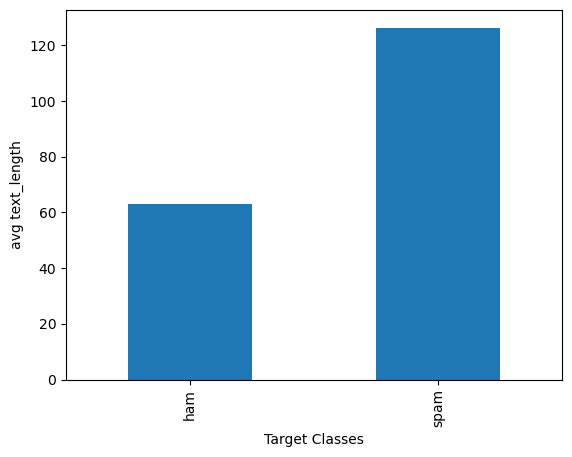

In [834]:
final_df.groupby("target").text_length.mean().plot(kind='bar')
plt.xlabel("Target Classes")
plt.ylabel("avg text_length")
plt.show()

In [835]:
final_df.groupby("target").word_count.mean()

target
ham     14.579052
spam    25.237366
Name: word_count, dtype: float64

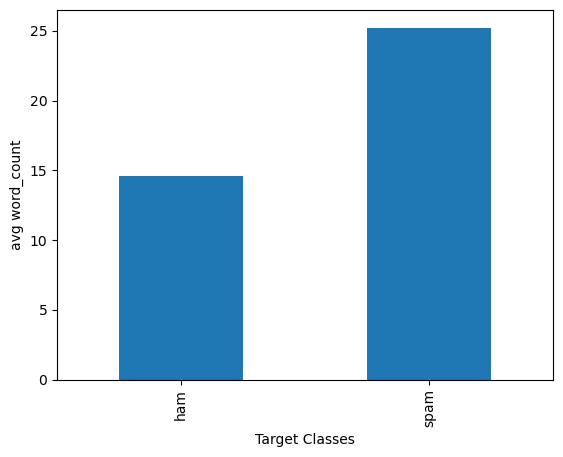

In [836]:
final_df.groupby("target").word_count.mean().plot(kind='bar')
plt.xlabel("Target Classes")
plt.ylabel("avg word_count")
plt.show()

In [837]:
final_df.groupby("target").avg_word_length.mean()

target
ham     3.432451
spam    4.109046
Name: avg_word_length, dtype: float64

### **Experiement with data to find the uncleaned data:**

In [839]:
final_df.columns

Index(['text', 'text_length', 'word_count', 'avg_word_length', 'target'], dtype='object')

In [841]:
cleaned_df.loc[2935:2936,:]

,text,target
2935,staff science nus edu sg phyhcmk teaching pc1323,ham
2936,have you emigrated or something ok maybe 5 30...,ham


In [842]:
final_df[final_df.text_length==0]

,text,text_length,word_count,avg_word_length,target
3191,,0,0,0.0,ham
4500,,0,0,0.0,ham


In [843]:
df.loc[4500:4501,:]

,text,target
4500,:-) :-),ham
4501,Not thought bout it... || Drink in tap & spile...,ham


In [844]:
df.loc[3191:3192,:]

,text,target
3191,:),ham
3192,"Good afternon, my love. How are today? I hope ...",ham


In [845]:
final_df.loc[2935:2936,:]

,text,text_length,word_count,avg_word_length,target
2935,staff scienc nu edu sg phyhcmk teach pc1323,43,8,4.5,ham
2936,have you emigr or someth ok mayb 5 30 wa a bit...,51,13,3.0,ham


## **Make a pipeline for target column**

In [847]:
# Define the target pipeline
target_pipe = Pipeline(steps=[
    ('encoding', LabelEncoder())  
])
target_pipe


Pipeline(steps=[('encoding', LabelEncoder())])

## **Make pipeline for input columns**

In [891]:
from sklearn import set_config

set_config(transform_output='pandas')

# Define the text processing pipeline
text_pipe = Pipeline(steps=[
    ('tf-idf', TfidfVectorizer(max_features=500))
])

text_pipe

Pipeline(steps=[('tf-idf', TfidfVectorizer(max_features=500))])

## **Split the data:**

In [851]:
x=final_df.iloc[:,:-1]
y=final_df.iloc[:,-1]

xtrain,xtest,ytrain,ytest= train_test_split(x,y,test_size=.2,random_state=42)
print('The shape of training data is',xtrain.shape)
print('The shape of testing data is',xtest.shape)

The shape of training data is (4135, 4)
The shape of testing data is (1034, 4)
